# Visualize

## Import libraries

In [1]:
import os, sys

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import cv2
from tabulate import tabulate

sys.path.append(os.path.join('..', '..'))

## Configuration

### Participants meta

In [2]:
had_glasses = {
    'P2': False,
    'P3': True,
    'P4': False,
    'P5': False,
    'P6': False,
    'P7': False,
    'P8': False,
    'P9': True,
    'P10': False,
    'P11': False,
    'P12': False,
    'P13': False,
    'P14': False,
    'P15': True,
    'P16': False,
    'P17': False,
    'P18': True,
    'P19': False,
    'P20': False,
    'P21': True,
    'P22': False,
    'P23': True,
    'P24': False,
    'P25': False,
    'P26': True,
    'P27': False,
    'P28': False,
    'P29': False,
    'P30': False,
    'P31': False,
}

participants_with_glasses = []

for key, value in had_glasses.items():
    if value is True:
        participants_with_glasses.append(key)

unique_stimuli = ['Top left', 'Top center', 'Top right',
              'Middle left', 'Middle center', 'Middle right',
              'Bottom left', 'Bottom center', 'Bottom right']
        
gaze_truth = {
    'Top left': (162, 132),
    'Top center': (960, 132),
    'Top right': (1758, 132),
    'Middle left': (162, 540),
    'Middle center': (960, 540),
    'Middle right': (1758, 540),
    'Bottom left': (162, 948),
    'Bottom center': (960, 948),
    'Bottom right': (1758, 948),
}

screen = (1920, 1080)

scale_parameter = 2


# https://www.spectratech.gr/Web/Tobii/pdf/TX300.pdf
# https://onlinelibrary.wiley.com/doi/full/10.1111/infa.12441
# 51.1 × 28.7 cm // 23'' variant
# 52.7 × 29.6 cm // 24'' variant

screen_width_px = 1920
screen_width_mm = 511

screen_height_px = 1080
screen_height_mm = 287

## Functions

### Metrics calculations

In [3]:
def calculate_pixel_error(row, x_pred, y_pred):
    gaze_truth_point = gaze_truth[row['Stimul']]
    x = gaze_truth_point[0]
    y = gaze_truth_point[1]
    
    return np.sqrt(np.sum(np.square(np.array([x_pred - x, y_pred - y]))))


def calculate_on_screen_distance_error(row, x_pred, y_pred):
    gaze_truth_point = gaze_truth[row['Stimul']]
    x = gaze_truth_point[0]
    y = gaze_truth_point[1]
    
    x = (x / screen_width_px) * screen_width_mm
    x_pred = (x_pred / screen_width_px) * screen_width_mm

    y = (y / screen_height_px) * screen_height_mm
    y_pred = (y_pred / screen_height_px) * screen_height_mm

    return np.sqrt(np.sum(np.square(np.array([x_pred - x, y_pred - y]))))

def calculate_metrics(df):
    # Tobii
    df['Pixel_error_Tobii'] = df.apply(lambda row: calculate_pixel_error(row, row['Fixation_X'], row['Fixation_Y']), axis=1)
    df['On_screen_distance_Tobii'] = df.apply(lambda row: calculate_on_screen_distance_error(row, row['Fixation_X'], row['Fixation_Y']), axis=1)

    # RN18 SW Attention
    df['Pixel_error_Rage-Net'] = df.apply(lambda row: calculate_pixel_error(row, row['Rage-Net_X'], row['Rage-Net_Y']), axis=1)
    df['On_screen_distance_Rage-Net'] = df.apply(lambda row: calculate_on_screen_distance_error(row, row['Rage-Net_X'], row['Rage-Net_Y']), axis=1)

    return df
    
def drop_outliers(df):
    # Keep only rows, where Tobii OSD is lower than 50 mm
    df = df.loc[df['On_screen_distance_Tobii'] < 50, :]

    # Keep only rows, where CNN OSD is lower than 100 mm
    df = df.loc[df['On_screen_distance_Rage-Net'] < 100, :]
    
    return df

def aggregate_and_plt_osd_metric(df):
    table_header = ['Block', 'Rows', 'OSD - Tobii', 'OSD - RN18-v2']
    table_data = []

    for index in range(6):
        case_x = df.loc[df['Case'] == f'case_{index + 1}', ['On_screen_distance_Tobii', 'On_screen_distance_Rage-Net']]
        table_data.append([f'Block {index + 1}',
                           len(case_x),
                           case_x['On_screen_distance_Tobii'].mean(),
                           case_x['On_screen_distance_Rage-Net'].mean()])

    print(tabulate(table_data, headers=table_header, tablefmt="fancy_outline"))

def get_column_without_nulls(df_subset, column):
    return df_subset.loc[df_subset[column].notna()][column]

def column_to_cases(df_subset, column):
    df_subset_not_na = df_subset.loc[df_subset[column].notna()]
    return [df_subset_not_na.loc[df_subset_not_na['Case'] == f'case_{index + 1}'][column] for index in range(6)]        

def describe_data(df_subsets, subset_labels):
    table_data = []
    table_header = ['', 'Count', 'Mean', 'STD', 'Min', '25%', '50%', '75%', 'Max', 'Skewness', 'Kurtosis']

    for index, subset in enumerate(df_subsets):
        table_data.append([subset_labels[index]] + subset.describe().to_list() + [subset.skew(), subset.kurtosis()])

    print(tabulate(table_data, headers=table_header, tablefmt="fancy_outline"))

### Functions for plotting predicted and ground truth points

In [4]:
# Constants
cmap = matplotlib.cm.get_cmap('gray')
cmap_offset = 0.1

radius_max = 4
radius_min = 1.5

def get_rgb_color(osd, osd_max):
    rgba = cmap(osd / (osd_max * 2.5) + cmap_offset)
    return np.array(rgba[:3]) * 255
            
def get_scaled_radius(osd, osd_max):
    return radius_max - round((osd / osd_max) * (radius_max - radius_min))

def add_predicted_point(img, coordinates, osd, osd_max):
    scaled_coordinates = np.array(coordinates, dtype=np.uint16) * scale_parameter
    
    # Static radius and color
    radius = radius_max
    cv2.circle(img, scaled_coordinates, radius=round(radius * scale_parameter), color=(0, 0, 0), thickness=-1, lineType=cv2.LINE_AA)
    
def add_ground_truth_points(img, avg_px=None, stimul=None):
    items = gaze_truth.items() if stimul is None else [(stimul, gaze_truth[stimul])]
    for _, val in items:
        scaled_coordinates = np.array(val) * scale_parameter
        cv2.circle(img, scaled_coordinates, radius=12 * scale_parameter, color=(255, 0, 0), thickness=-1, lineType=cv2.LINE_AA)
        cv2.circle(img, scaled_coordinates, radius=5 * scale_parameter, color=(0, 0, 0), thickness=-1, lineType=cv2.LINE_AA)
        
        if avg_px is not None:
            cv2.circle(img, scaled_coordinates, radius=round(avg_px * scale_parameter), color=(120, 120, 120), thickness=1 * scale_parameter, lineType=cv2.LINE_AA)

In [5]:
def create_tobii_img(df, max_osd, file = None, save_as_gray=False, avg_px=None):
    # Create white image
    visualization_tobii = np.full((screen[1] * scale_parameter, screen[0] * scale_parameter, 3), 255, dtype=np.uint8)
    
    df_no_null = df.loc[df['On_screen_distance_Tobii'].notna()]
    
    df_no_null.apply(lambda row: add_predicted_point(visualization_tobii, (row['Fixation_X'], row['Fixation_Y']), 
                                             row['On_screen_distance_Tobii'], max_osd), axis=1)
    
    # Add ground truth points
    add_ground_truth_points(visualization_tobii, avg_px=avg_px)

    # Save img
    if file is not None:
        cv2.imwrite(file, cv2.cvtColor(visualization_tobii, cv2.COLOR_RGB2BGR) if not save_as_gray else cv2.cvtColor(visualization_tobii, cv2.COLOR_RGB2GRAY))

    return visualization_tobii

def create_rn_18_sw_img(df, max_osd, file=None, save_as_gray=False, avg_px=None, stimul=None):
    # CNN
    visualization_rn_18_sw = np.full((screen[1] * scale_parameter, screen[0] * scale_parameter, 3), 255, dtype=np.uint8)
    df.apply(lambda row: add_predicted_point(visualization_rn_18_sw, (row['Rage-Net_X'], row['Rage-Net_Y']), 
                                             row['On_screen_distance_Rage-Net'], max_osd), axis=1)
    
    # Add ground truth points
    add_ground_truth_points(visualization_rn_18_sw, avg_px=avg_px, stimul=stimul)

    # Save img
    if file is not None:
        cv2.imwrite(file, cv2.cvtColor(visualization_rn_18_sw, cv2.COLOR_RGB2BGR))
    
    return visualization_rn_18_sw

def visualize_metrics(df, file_tobii, file_rn_18_sw, max_osd, 
                                    save_as_gray=False, figsize=(10, 4), 
                                    avg_px_tobii=None, avg_px_rn_18_sw=None, title= None):
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes = axes.ravel() # 2D to 1D list
    if title is not None:
        fig.suptitle(title)
    

    tobii_img = create_tobii_img(df, max_osd, file_tobii, save_as_gray=save_as_gray, avg_px=avg_px_tobii)
    rn18_sw_img = create_rn_18_sw_img(df, max_osd, file_rn_18_sw, save_as_gray=save_as_gray, avg_px=avg_px_rn_18_sw)
    
    axes[0].imshow(tobii_img)
    axes[0].axis('off')

    axes[1].imshow(rn18_sw_img)
    axes[1].axis('off')
    
    plt.show()
    
def visualize_rn_18_sw_separate(df, max_osd, save_as_gray=False, figsize=(10, 4), file_suffix='', avg_px_rn_18_sw=None, save_to_file=False):
    # Create figure
    fig, axes = plt.subplots(3, 3, figsize=figsize)
    axes = axes.ravel() # 2D to 1D list
    
    for ax, stimul in zip(axes, unique_stimuli):
        file =  f'./exports/Rage-Net/Rage-Net{file_suffix}--{stimul.lower().replace(" ", "-")}.png' if save_to_file else None
        rn_18_sw_img = create_rn_18_sw_img(df.loc[df['Stimul'] == stimul], max_osd, file, save_as_gray=save_as_gray, avg_px=avg_px_rn_18_sw, stimul=stimul)

        ax.imshow(rn_18_sw_img)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
        for spine in ax.spines.values():
            spine.set_edgecolor('#ddd')
    
    plt.show()

## Visualizations (with okuliarmi and without glasses)

In [6]:
data_directory = '../../Datasets/Study_2/Meta.tsv'
df = pd.read_csv(data_directory, header=0, delimiter='\t')

# Calculate metrics
df = calculate_metrics(df)

# Split to with and without glasses
df_with_glasses = df.loc[df['Participant'].isin(participants_with_glasses), :]
df_no_glasses = df.loc[~df['Participant'].isin(participants_with_glasses), :]

# Max, Avg OSD values
max_osd_tobii = df['On_screen_distance_Tobii'].max()
avg_px_tobii = df['Pixel_error_Tobii'].mean()

max_osd_rn_18_sw = df['On_screen_distance_Rage-Net'].max()
avg_px_rn_18_sw = df['Pixel_error_Rage-Net'].mean()

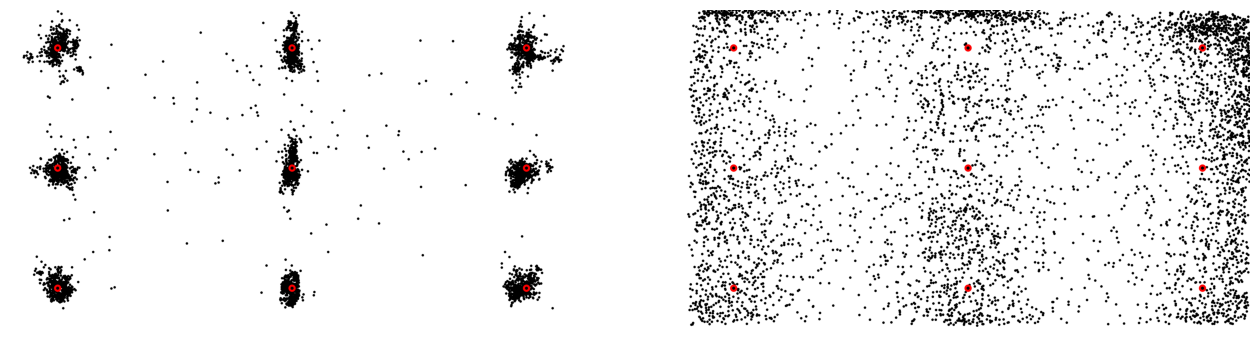

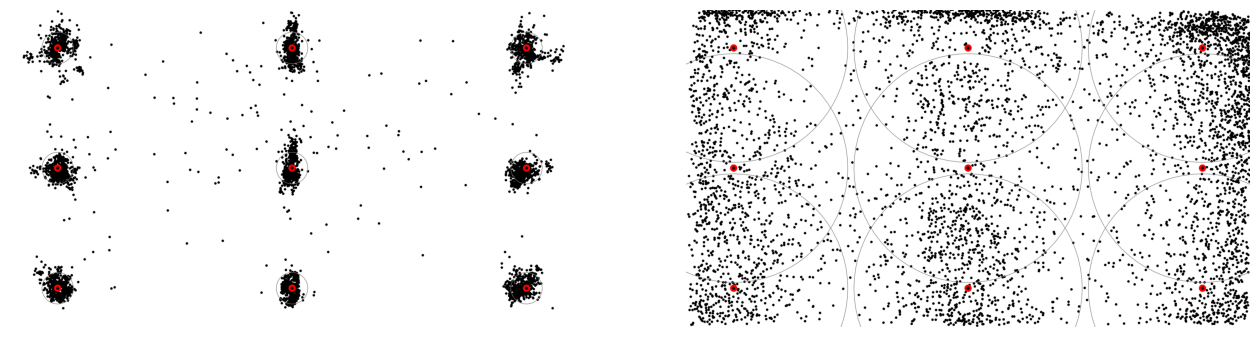

In [7]:
# Without avg circle
visualize_metrics(df, None, None, max_osd_tobii, save_as_gray=False, figsize=(16, 5))

# With avg
visualize_metrics(df, None, None, max_osd_tobii, save_as_gray=False, figsize=(16, 5),
                                avg_px_tobii=avg_px_tobii, avg_px_rn_18_sw=avg_px_rn_18_sw)

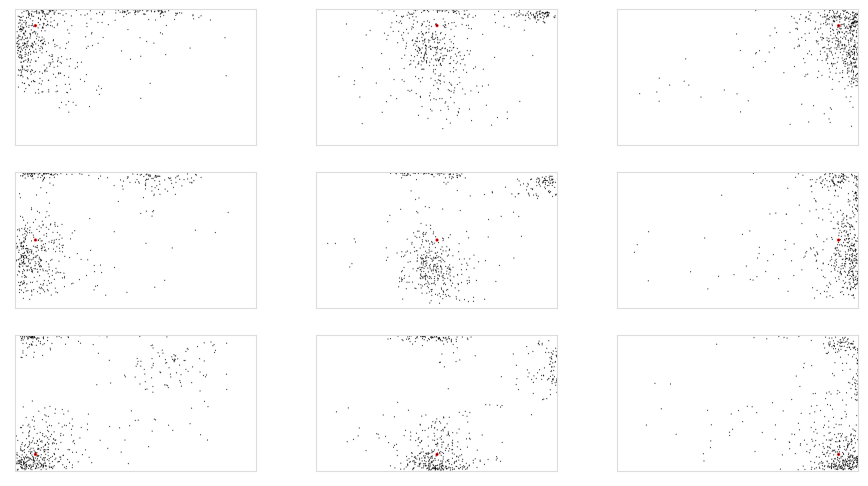

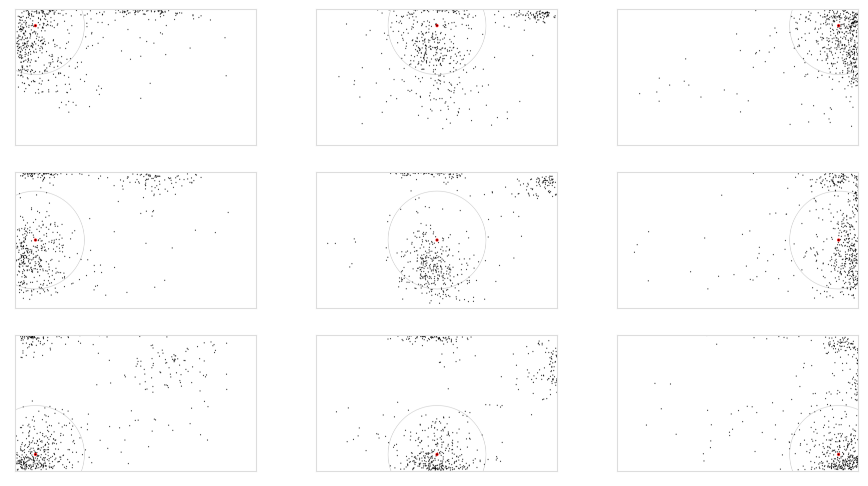

In [8]:
visualize_rn_18_sw_separate(df, max_osd_tobii, save_as_gray=False, figsize=(11, 6))
visualize_rn_18_sw_separate(df, max_osd_tobii, save_as_gray=False, figsize=(11, 6), file_suffix='--avg-circle', avg_px_rn_18_sw=avg_px_rn_18_sw)

## Visualizations for each stimul separately (with okuliarmi and without glasses)

In [9]:
def group_by_case(df):
    for index in range(6):
        case = f'case_{index + 1}'
        
        df_case = df.loc[df['Case'] == case]

        
        # Max, Avg OSD values
        max_osd_tobii = df_case['On_screen_distance_Tobii'].max()
        avg_px_tobii = df_case['Pixel_error_Tobii'].mean()

        max_osd_rn_18_sw = df_case['On_screen_distance_Rage-Net'].max()
        avg_px_rn_18_sw = df_case['Pixel_error_Rage-Net'].mean()

        visualize_metrics(df_case, None, None, max_osd_tobii, save_as_gray=False, figsize=(16, 5), title=case)

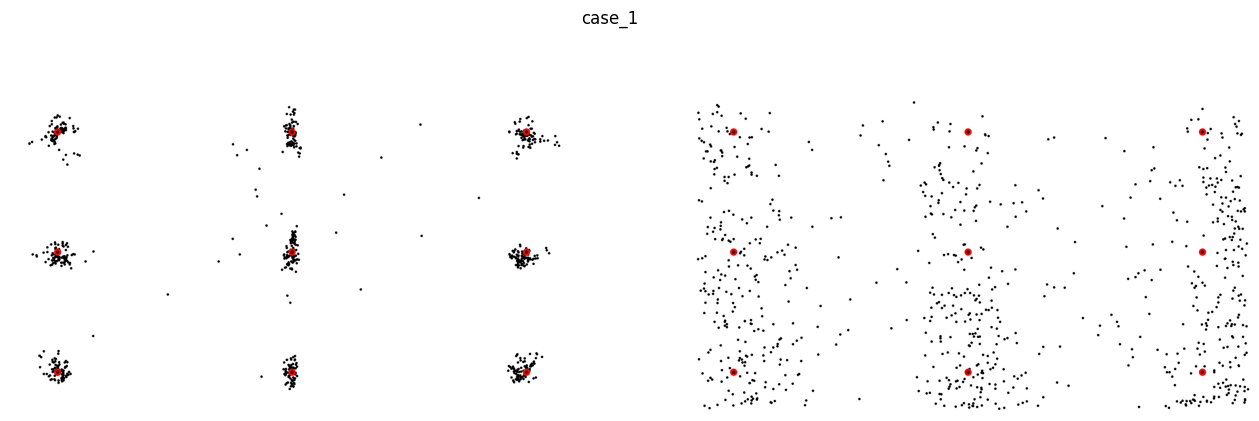

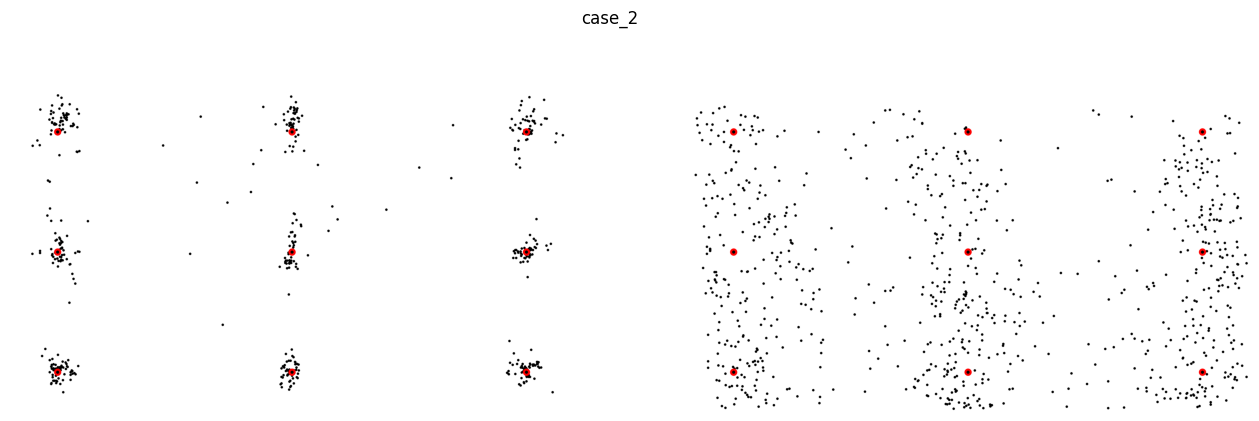

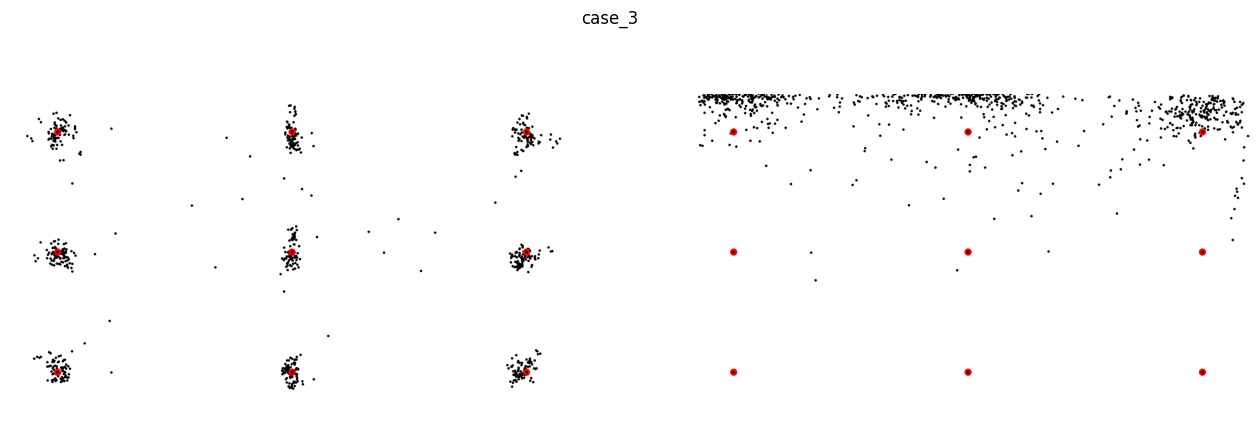

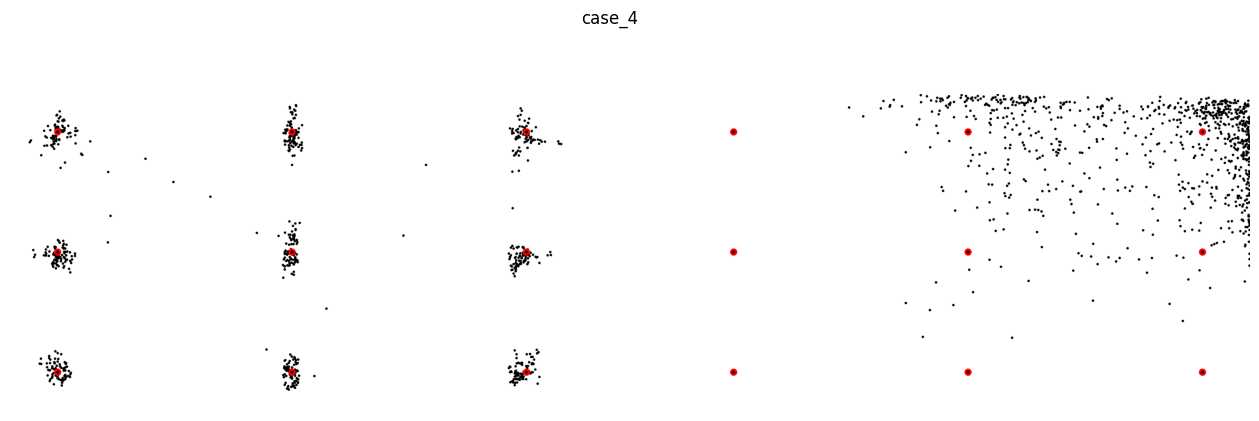

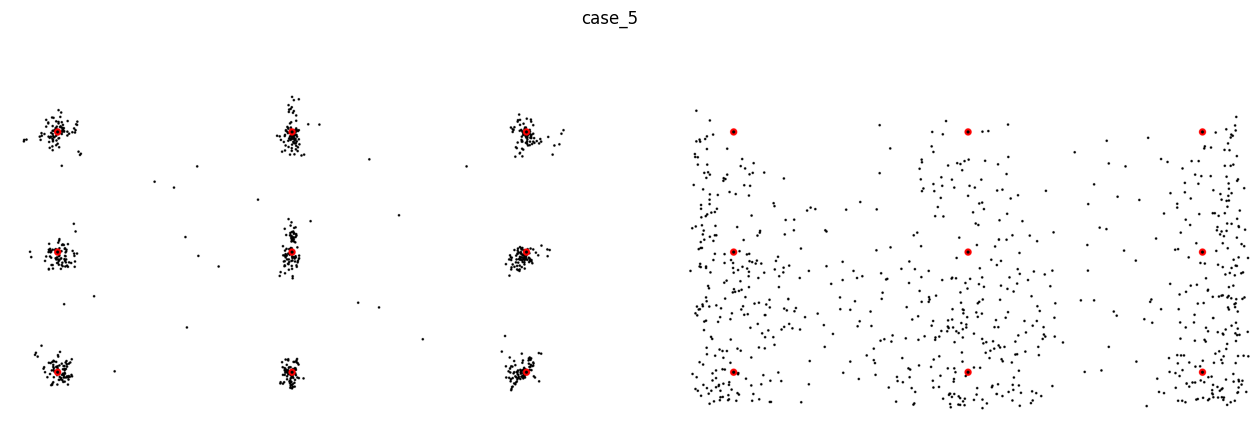

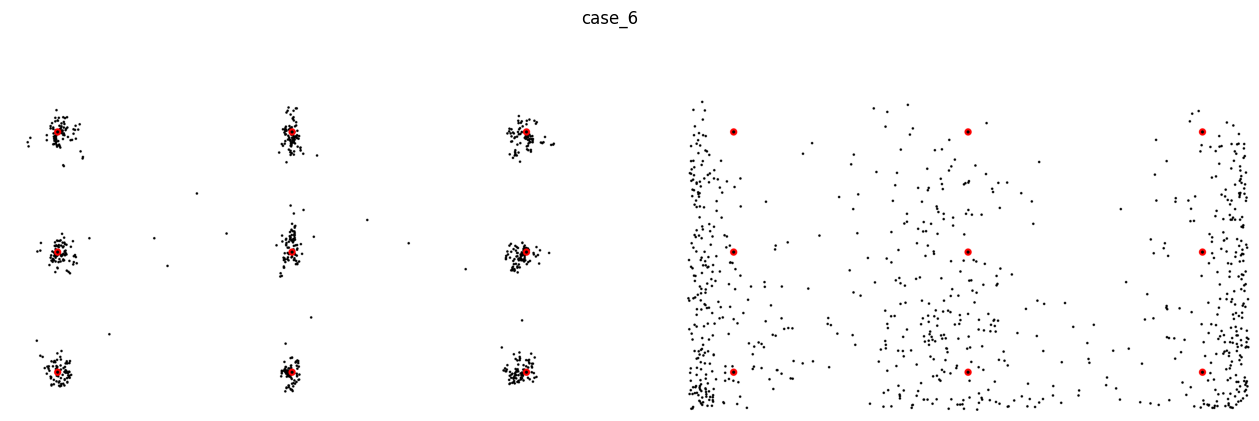

In [10]:
data_directory = '../../Datasets/Study_2/Meta.tsv'
df = pd.read_csv(data_directory, header=0, delimiter='\t')

# Calculate metrics
df = calculate_metrics(df)
group_by_case(df)

## Case_1 split through stimuli

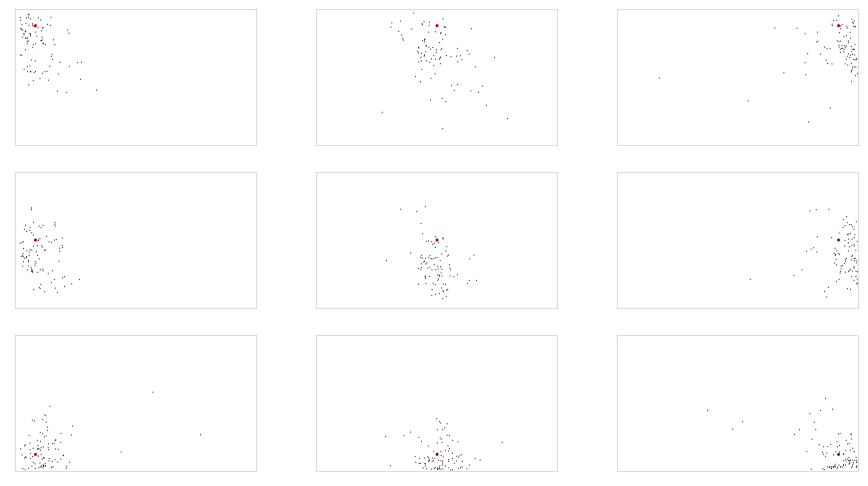

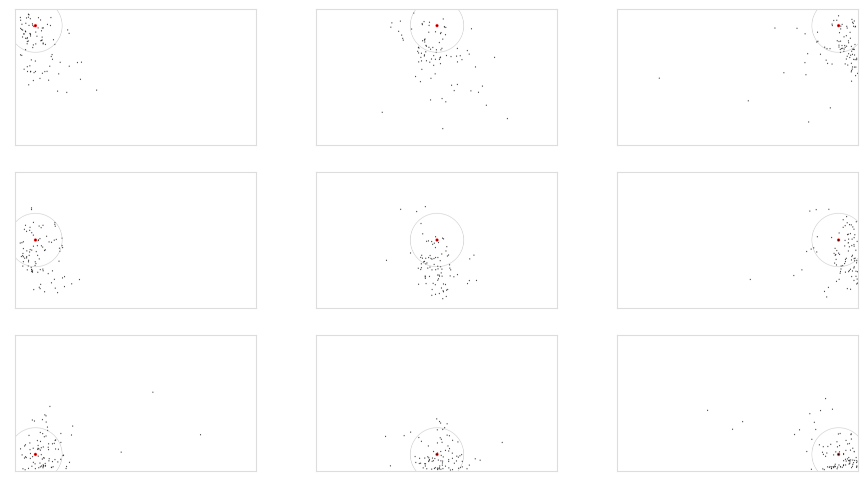

In [11]:
df_case = df.loc[df['Case'] == 'case_1']

# Max, Avg OSD values
max_osd_tobii = df_case['On_screen_distance_Tobii'].max()
avg_px_tobii = df_case['Pixel_error_Tobii'].mean()

max_osd_rn_18_sw = df_case['On_screen_distance_Rage-Net'].max()
avg_px_rn_18_sw = df_case['Pixel_error_Rage-Net'].mean()

visualize_rn_18_sw_separate(df_case, max_osd_tobii, save_as_gray=False, figsize=(11, 6), file_suffix='-case_1')
visualize_rn_18_sw_separate(df_case, max_osd_tobii, save_as_gray=False, figsize=(11, 6), file_suffix='-case_1--avg-circle', avg_px_rn_18_sw=avg_px_rn_18_sw)

## Best participant for each cases

**Note:** Best participant was choosen by Rage-Net OSD

In [12]:
data_directory = '../../Datasets/Study_2/Meta.tsv'
df = pd.read_csv(data_directory, header=0, delimiter='\t')
df = calculate_metrics(df)

# OSD for participants
df.groupby(['Participant'])['On_screen_distance_Rage-Net'].mean().sort_values() #. mean()

Participant
P12     81.353080
P14     82.696938
P17     83.729975
P27     84.087538
P8      88.420876
P30     88.453578
P13     88.612584
P16     91.120285
P11     91.683864
P7      94.418314
P22     94.559132
P25     95.800233
P2      95.915319
P23     97.035444
P19     99.300046
P5     100.159859
P20    100.838811
P4     101.231383
P31    101.736990
P24    101.762234
P6     104.480986
P3     106.098355
P10    107.518927
P15    120.112049
P26    120.811976
P28    121.282266
P9     123.765461
P18    139.483864
P29    140.128252
P21    152.148622
Name: On_screen_distance_Rage-Net, dtype: float64

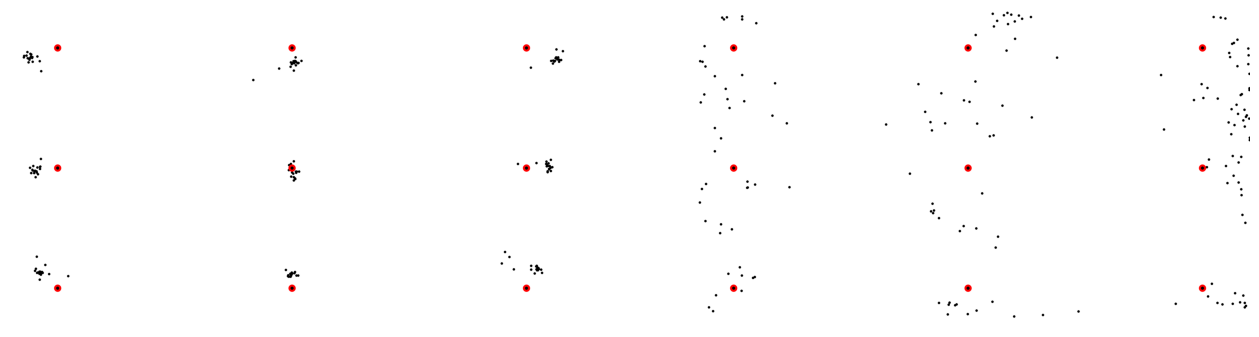

In [13]:
df_p12 = df.loc[df['Participant'] == 'P12']

# Max, Avg OSD values
max_osd_tobii = df_p12['On_screen_distance_Tobii'].max()
avg_px_tobii = df_p12['Pixel_error_Tobii'].mean()

max_osd_rn_18_sw = df_p12['On_screen_distance_Rage-Net'].max()
avg_px_rn_18_sw = df_p12['Pixel_error_Rage-Net'].mean()

visualize_metrics(df_p12, None, None, max_osd_tobii, save_as_gray=False, figsize=(16, 5))

## Best participant for best case (the best environment)

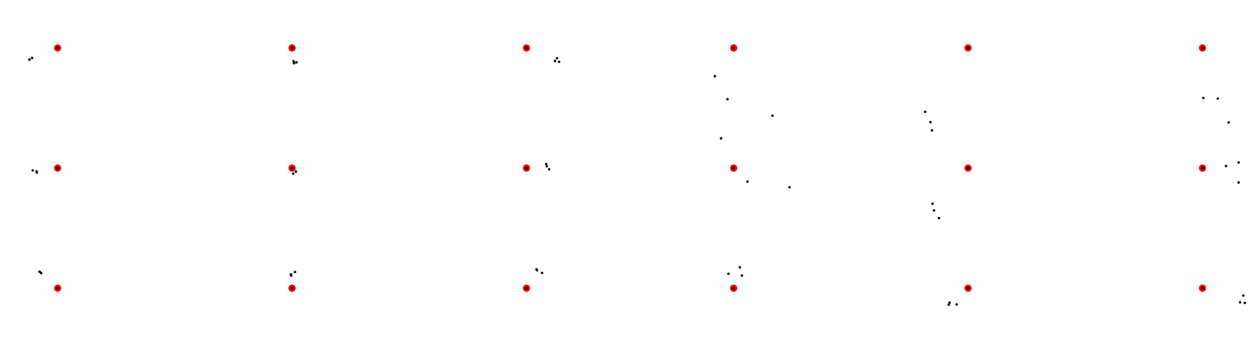

In [14]:
df_p12 = df.loc[(df['Participant'] == 'P12') & (df['Case'] == 'case_1')]

# Max, Avg OSD values
max_osd_tobii = df_p12['On_screen_distance_Tobii'].max()
avg_px_tobii = df_p12['Pixel_error_Tobii'].mean()

max_osd_rn_18_sw = df_p12['On_screen_distance_Rage-Net'].max()
avg_px_rn_18_sw = df_p12['Pixel_error_Rage-Net'].mean()

visualize_metrics(df_p12, None, None, max_osd_tobii, save_as_gray=False, figsize=(16, 5))

## Worst participant for all cases 

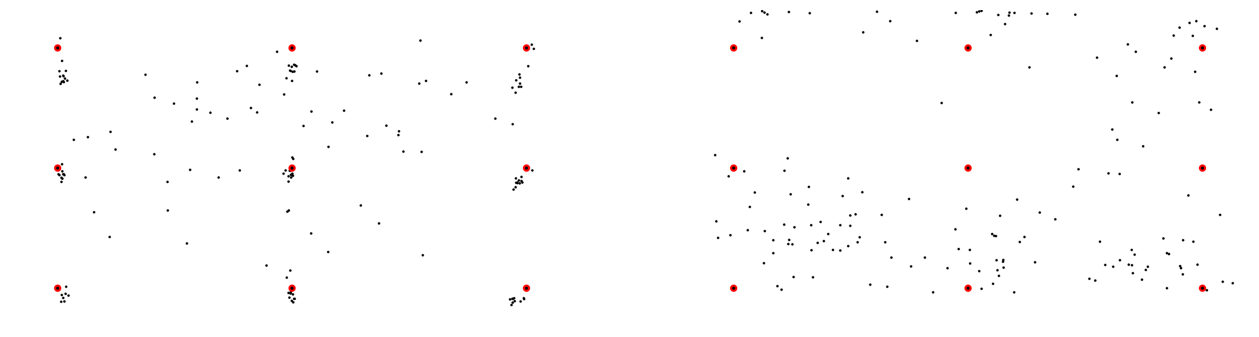

In [15]:
df_p21 = df.loc[df['Participant'] == 'P21']

# Max, Avg OSD values
max_osd_tobii = df_p21['On_screen_distance_Tobii'].max()
avg_px_tobii = df_p21['Pixel_error_Tobii'].mean()

max_osd_rn_18_sw = df_p21['On_screen_distance_Rage-Net'].max()
avg_px_rn_18_sw = df_p21['Pixel_error_Rage-Net'].mean()

visualize_metrics(df_p21, None, None, max_osd_tobii, save_as_gray=False, figsize=(16, 5))

## Worst participant for worst case (environment)

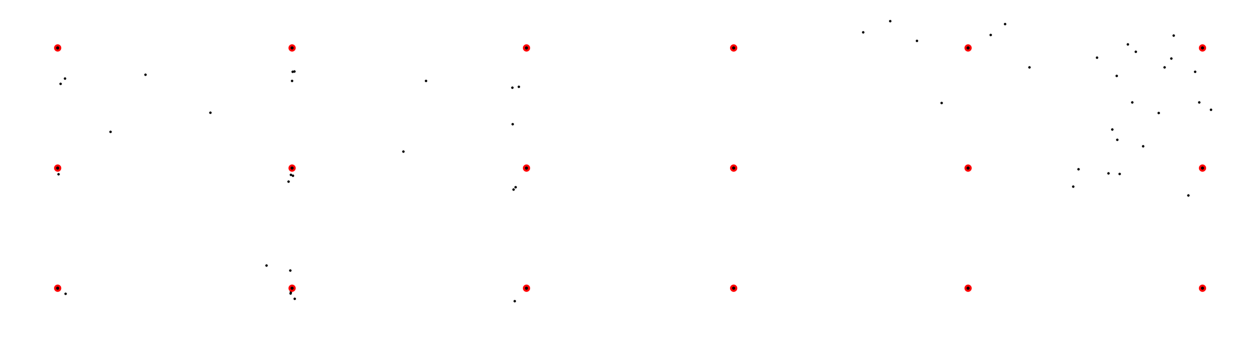

In [16]:
df_p21 = df.loc[(df['Participant'] == 'P21') & (df['Case'] == 'case_4')]

# Max, Avg OSD values
max_osd_tobii = df_p21['On_screen_distance_Tobii'].max()
avg_px_tobii = df_p21['Pixel_error_Tobii'].mean()

max_osd_rn_18_sw = df_p21['On_screen_distance_Rage-Net'].max()
avg_px_rn_18_sw = df_p21['Pixel_error_Rage-Net'].mean()

visualize_metrics(df_p21, None, None, max_osd_tobii, save_as_gray=False, figsize=(16, 5))